In this exercise we will classify stimulus classes using the Haxby et al. data. 

In [1]:
import nipype.algorithms.modelgen as model   # model generation
import nipype.interfaces.fsl as fsl          # fsl
from nipype.interfaces.base import Bunch
import os,json,glob
import numpy
import nibabel
import nilearn.plotting
import sklearn.multiclass
from sklearn.svm import SVC
import sklearn.metrics
import sklearn.cross_validation
from nilearn.input_data import NiftiMasker
import scipy.stats
import random
import nilearn.datasets
from haxby_data import HaxbyData

haxby_dataset = nilearn.datasets.fetch_haxby()
boldfile=haxby_dataset.func[0]
datadir=os.path.dirname(boldfile)

print('using data from %s'%datadir)
haxbydata=HaxbyData(datadir)

%matplotlib inline
import matplotlib.pyplot as plt

boldimg=nibabel.load(boldfile)

if not os.path.exists(boldfile.replace('.nii.gz','_brain.nii.gz')):
    bet=fsl.BET()
    bet.inputs.in_file=boldfile
    bet.inputs.out_file=boldfile.replace('.nii.gz','_brain.nii.gz')
    bet.inputs.functional=True
    bet.inputs.mask=True
    bet.run()


brainmaskimg=nibabel.load(boldfile.replace('.nii.gz','_brain_mask.nii.gz'))
vtmaskimg=nibabel.load(haxby_dataset.mask_vt[0])

# set up design info


using data from /home/vagrant/nilearn_data/haxby2001/subj1


Set up model


In [2]:
modeldir=os.path.join(datadir,'blockmodel')
# no way to specify the output directory, so we just chdir into the 
# desired output directory
if not os.path.exists(modeldir):
    os.mkdir(modeldir)
os.chdir(modeldir)


Estimate the model with a separate condition for each block using FSL.  This will take several hours to finish.

In [3]:
not os.path.exists(os.path.join(modeldir,'stats/zstat1.nii.gz'))

False

In [4]:
contrasts=[]

for i in range(len(haxbydata.conditions)):
    contrasts.append([haxbydata.conditions[i],'T',[haxbydata.conditions[i]],[1]])


# this is how one could do it using FSL - this is VERY slow, so let's compute the GLM on our own
if not os.path.exists(os.path.join(modeldir,'stats/zstat1.nii.gz')):
    
    
    info = [Bunch(conditions=haxbydata.conditions,
                  onsets=haxbydata.onsets,
                  durations=haxbydata.durations)
           ]
    s = model.SpecifyModel()
    s.inputs.input_units = 'secs'
    s.inputs.functional_runs = [haxbydata.boldbrainfile]
    s.inputs.time_repetition = haxbydata.tr
    s.inputs.high_pass_filter_cutoff = 128.
    s.inputs.subject_info = info
    s.run()

    level1design = fsl.model.Level1Design()
    level1design.inputs.interscan_interval = haxbydata.tr
    level1design.inputs.bases = {'dgamma':{'derivs': False}}
    level1design.inputs.session_info = s._sessinfo
    level1design.inputs.model_serial_correlations=False
    level1design.inputs.contrasts=contrasts
    level1info=level1design.run() 
    
    fsf_file=os.path.join(modeldir,'run0.fsf')
    matfile=fsf_file.replace(".fsf",".mat")
    event_files=glob.glob(os.path.join(modeldir,'ev*txt'))

    modelgen=fsl.model.FEATModel()
    modelgen.inputs.fsf_file=fsf_file
    modelgen.inputs.ev_files=event_files
    modelgen.run()

    fgls = fsl.FILMGLS(autocorr_noestimate=True)
    fgls.inputs.in_file =haxbydata.boldbrainfile
    fgls.inputs.design_file = os.path.join(modeldir,'run0.mat')
    fgls.inputs.threshold = 10
    fgls.inputs.results_dir = os.path.join(modeldir,'stats')
    fgls.inputs.tcon_file=os.path.join(modeldir,'run0.con')
    res = fgls.run() 

else:
    print('stats have already been run - using existing files')


stats have already been run - using existing files


Load the zstat images that we will use as our block-by-block signal estimates

In [5]:
use_whole_brain=False

# include faces and cats
condition_mask = numpy.logical_or(haxbydata.condnums == 2,
                               haxbydata.condnums == 3)
condlabels=haxbydata.condnums[condition_mask]
runlabels=haxbydata.runs[condition_mask]

if not os.path.exists(os.path.join(modeldir,'zstatdata_facecat.nii.gz')):
    zstatdata=numpy.zeros((boldimg.shape[0],boldimg.shape[1],boldimg.shape[2],len(haxbydata.conditions)))
    for i in range(len(haxbydata.conditions)):
        zstatdata[:,:,:,i]=nibabel.load(os.path.join(modeldir,'stats/zstat%d.nii.gz'%int(i+1))).get_data()

    zstatimg=nibabel.Nifti1Image(zstatdata,affine=brainmaskimg.get_affine())
    zstatimg.to_filename(os.path.join(modeldir,'zstatdata.nii.gz'))
    zstatimg=nibabel.Nifti1Image(zstatdata[:,:,:,condition_mask],affine=brainmaskimg.get_affine())
    zstatimg.to_filename(os.path.join(modeldir,'zstatdata_facecat.nii.gz'))

if use_whole_brain:
    maskimg=haxbydata.brainmaskfile
else:
    maskimg=haxbydata.vtmaskfile
    
nifti_masker = NiftiMasker(mask_img=maskimg, standardize=False)
fmri_masked = nifti_masker.fit_transform(os.path.join(modeldir,'zstatdata.nii.gz'))
fmri_masked = fmri_masked[condition_mask,:]



Now let's do a leave-one-run out classifier.

In [6]:
def shuffle_within_runs(labels,runs):
    for r in numpy.unique(runs):
        l=labels[runs==r]
        random.shuffle(l)
        labels[runs==r]=l
    return labels


def run_classifier(fmri_masked,condlabels,runs,baseclf,shuffle_labels=False):
    cv = sklearn.cross_validation.LeaveOneLabelOut(labels=runs)

    pred=numpy.zeros(len(runs)) # predicted class

    if len(numpy.unique(condlabels))>2:
        clf=sklearn.multiclass.OneVsRestClassifier(baseclf)
    else:
        clf=baseclf
    
    for train,test in cv:
        testdata=fmri_masked[test,:]
        traindata=fmri_masked[train,:]
        trainlabels=condlabels[train]
        if shuffle_labels:
            trainlabels=shuffle_within_runs(trainlabels,runs[train])
        clf.fit(traindata,trainlabels)
        pred[test]=clf.predict(testdata)
        
    confmtx=sklearn.metrics.confusion_matrix(condlabels,pred)
    acc=sklearn.metrics.accuracy_score(condlabels,pred)
    return pred,confmtx,acc

pred,confmtx,acc=run_classifier(fmri_masked,condlabels,runlabels,SVC(kernel='linear'))



In [8]:
print(confmtx)
print('Accuracy score: %f'%acc)

[[9 3]
 [4 8]]
Accuracy score: 0.708333


Run the classifier repeatedly using random labels to get a null distribution

In [9]:
nperms=500
randacc=numpy.zeros(nperms)
condlabels_rand=condlabels.copy()
for i in range(nperms):
    _,_,randacc[i]=run_classifier(fmri_masked,condlabels_rand,
                                  runlabels,
                                  SVC(kernel='linear'),
                                  shuffle_labels=True)


In [10]:
pct=scipy.stats.percentileofscore(randacc,acc)
print('Pval:',(100-pct)/100.0)


Pval: 0.015


Now let's set up a searchlight analysis

In [11]:
import nilearn.decoding 
slradius=8
sl=nilearn.decoding.SearchLight(mask_img=vtmaskimg,radius=slradius)
sl.fit(nibabel.load(os.path.join(modeldir,'zstatdata_facecat.nii.gz')),condlabels)


SearchLight(cv=None, estimator='svc',
      mask_img=<nibabel.nifti1.Nifti1Image object at 0x7fe549ce28d0>,
      n_jobs=1, process_mask_img=None, radius=8, scoring=None, verbose=0)

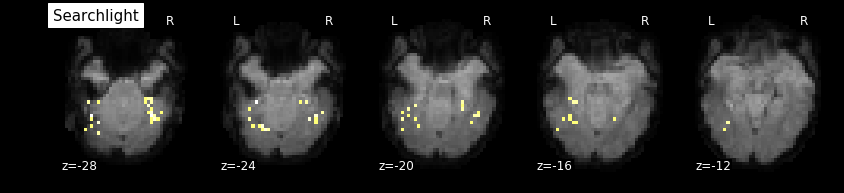

In [12]:
if not os.path.exists(haxbydata.boldfile.replace('.nii.gz','_brain_mean.nii.gz')):
    mean=fsl.maths.MeanImage(in_file=haxbydata.boldfile,
                             out_file=haxbydata.boldfile.replace('.nii.gz','_brain_mean.nii.gz'))
    mean.run()

mean_fmri=nibabel.load(haxbydata.boldfile.replace('.nii.gz','_brain_mean.nii.gz'))
nilearn.plotting.plot_stat_map(nibabel.Nifti1Image(sl.scores_,
                mean_fmri.get_affine()), mean_fmri,
                title="Searchlight", display_mode="z", cut_coords=[-28,-24,-20,-16,-12],
                colorbar=False,threshold=0.75)


Exercise: Change the searchlight radius and see how it affects the results.

Obtain a null distribution by running the searchligh 500 times, so we can compare the observed results to those expected by chance

In [13]:
nruns=500
maxscores=numpy.zeros(nruns)
sl_rand=nilearn.decoding.SearchLight(mask_img=vtmaskimg,radius=slradius)

for i in range(500):
    cl=shuffle_within_runs(condlabels,runlabels)
    sl_rand.fit(nibabel.load(os.path.join(modeldir,'zstatdata_facecat.nii.gz')),cl)
    maxscores[i]=numpy.max(sl_rand.scores_)
    


In [14]:
cutoff=scipy.stats.scoreatpercentile(maxscores,95)

In [17]:
print('95 pct null accuracy: %f'%cutoff)
print('N voxels > cutoff: %d'%numpy.sum(sl.scores_>cutoff))

95 pct null accuracy: 0.916667
N voxels > cutoff: 0
